In [1]:
import sys
sys.path.insert(0, '/home/users/brezovec/.local/lib/python3.6/site-packages/lib/python/')
import ants
import os
import bigbadbrain as bbb
import numpy as np
import matplotlib.pyplot as plt
import time
import scipy
from scipy.ndimage.filters import gaussian_filter
from scipy.ndimage.filters import gaussian_filter1d
from scipy.signal import savgol_filter
from scipy.interpolate import interp1d

from skimage.filters import threshold_triangle
sys.path.insert(0, '/home/users/brezovec/.local/lib/python3.6/site-packages')
import os
import statsmodels.api as sm
import cv2
import matplotlib.patches as mpatches
import psutil
from mpl_toolkits.axes_grid1 import ImageGrid
from matplotlib.colors import Normalize
import matplotlib.colors as mcolors
from matplotlib import colors

%matplotlib inline
plt.rcParams.update({'font.size': 20})

from sklearn.feature_extraction.image import grid_to_graph
from mpl_toolkits.axes_grid1 import ImageGrid
import json
from matplotlib.ticker import FuncFormatter

import nibabel as nib

from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import fcluster
from scipy.cluster import hierarchy
import itertools
import random
import matplotlib as mpl
from matplotlib.pyplot import cm

from scipy.interpolate import UnivariateSpline
from sklearn.linear_model import LinearRegression
import matplotlib.patches as patches

from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV

from scipy.fftpack import fft,fftshift,ifft
from scipy import signal
import pickle

In [2]:
############################
### Load super voxel ids ###
############################

n_clusters = 2000
labels_file = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20201129_super_slices/cluster_labels.npy'
cluster_model_labels = np.load(labels_file)

In [3]:
######################
### Load Anat ROIs ###
######################

res_LUKE = (0.65, 0.65, 1)
load_file = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/anat_templates/20210412_crude_rois_in_luke.nii'
mimic_moco = np.asarray(nib.load(load_file).get_data().squeeze(), dtype='float32')

# Want 512,1024,256
anat = np.swapaxes(mimic_moco,0,1)
print(anat.shape)

anat_iso = ants.resample_image(ants.from_numpy(anat),(int(512*0.65), int(1024*0.65), int(256*1)),1,0).numpy()

(512, 1024, 256)


In [4]:
FB = 26
rois = {'FB': 26, 'Medulla': 71, 'Lobula': 53, 'SLP_r': 27}
roi = 'FB'
anat_iso_mask = anat_iso.copy()
anat_iso_mask[np.where(anat_iso_mask != rois[roi])]=0
anat_iso_mask[np.where(anat_iso_mask != 0)]=1

In [171]:
fly_names = ['fly_087', 'fly_089', 'fly_094', 'fly_097', 'fly_098', 'fly_099', 'fly_100', 'fly_101', 'fly_105']

In [172]:
### Load indiv flies ###

to_load = ['thresholded_filters_norm', 'maxss', 'decay_times', 'peaks', 'to_delete']
all_data = {}
for load in to_load:
    print(load)
    all_data[load] = {}
    for fly in fly_names:
        main_path = F"/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20210210_neural_weighted_behavior_singles/{fly}"
        load_path = os.path.join(main_path, load + '.pickle')
        with open(load_path, 'rb') as handle:
            data = pickle.load(handle)
        all_data[load][fly] = data

thresholded_filters_norm
maxss
decay_times
peaks
to_delete


In [173]:
masked_XYs = {}
for fly in fly_names:
    print(fly)
    masked_XYs[fly] = {}
    for beh_idx in [0,1,2]:
        behs = ['Vf', 'Vr+', 'Vr-']
        add_deleted_voxels = np.zeros(98000)
        to_replace = [i for i in range(98000) if i not in all_data['to_delete'][fly][beh_idx][0]]
        #add_deleted_voxels[to_replace] = all_data['maxss'][fly][beh_idx]
        #add_deleted_voxels[to_replace] = all_data['peaks'][fly][beh_idx]
        peaks = np.argmax(all_data['thresholded_filters_norm'][fly][beh_idx][:,100:400],axis=-1)
        add_deleted_voxels[to_replace] = peaks
        
        to_plot = np.reshape(add_deleted_voxels, (49,2000))

        all_colored_by_betas = []
        for z in range(49):
            colored_by_betas = np.zeros(256*128)
            for cluster_num in range(len(np.unique(cluster_model_labels[z]))):
                cluster_indicies = np.where(cluster_model_labels[z]==cluster_num)[0]
                colored_by_betas[cluster_indicies] = to_plot[z,cluster_num]
            colored_by_betas = colored_by_betas.reshape(256,128)
            all_colored_by_betas.append(colored_by_betas)
        all_colored_by_betas = np.asarray(all_colored_by_betas)

        # want 128,256,49
        func = np.swapaxes(all_colored_by_betas,0,2)
        func_iso = ants.resample_image(ants.from_numpy(func),(int(512*0.65), int(1024*0.65), int(256*1)),1,1,).numpy()

        masked_XY = np.max(func_iso*anat_iso_mask,axis=2)
        masked_XY[np.where(masked_XY==0)] = np.nan
        masked_XYs[fly][beh_idx] = masked_XY
    
# for plotting
left_edge = np.where(np.sum(np.nan_to_num(masked_XY),axis=0)>0)[0][0]
right_edge = np.where(np.sum(np.nan_to_num(masked_XY),axis=0)>0)[0][-1]
top_edge = np.where(np.sum(np.nan_to_num(masked_XY),axis=1)>0)[0][0]
bottom_edge = np.where(np.sum(np.nan_to_num(masked_XY),axis=1)>0)[0][-1]
# deep_edge = np.where(np.sum(np.nan_to_num(masked_XZ),axis=0)>0)[0][0]
# shallow_edge = np.where(np.sum(np.nan_to_num(masked_XZ),axis=0)>0)[0][-1]
dim_x = right_edge-left_edge
dim_y = bottom_edge-top_edge
# dim_z = shallow_edge-deep_edge
dim_x = dim_x / 100
dim_y = dim_y / 100
# dim_z = dim_z / 100

fly_087
fly_089
fly_094
fly_097
fly_098
fly_099
fly_100
fly_101
fly_105


In [174]:
### load pooled fly ###
fly = 'pooled'
for load in to_load:
    print(load)
    main_path = "/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20210316_neural_weighted_behavior"
    load_path = os.path.join(main_path, load + '.pickle')
    with open(load_path, 'rb') as handle:
        data = pickle.load(handle)
    all_data[load][fly] = data

thresholded_filters_norm
maxss
decay_times
peaks
to_delete


In [175]:
fly = 'pooled'
masked_XYs[fly] = {}
for beh_idx in [0,1,2]:
    behs = ['Vf', 'Vr+', 'Vr-']
    add_deleted_voxels = np.zeros(62000)
    to_replace = [i for i in range(62000) if i not in all_data['to_delete'][fly][beh_idx][0]]
    #add_deleted_voxels[to_replace] = all_data['maxss'][fly][beh_idx]
    add_deleted_voxels[to_replace] = all_data['peaks'][fly][beh_idx]
    to_plot = np.reshape(add_deleted_voxels, (31,2000))

    all_colored_by_betas = []
    for z in range(9,49-9):
        colored_by_betas = np.zeros(256*128)
        for cluster_num in range(len(np.unique(cluster_model_labels[z]))):
            cluster_indicies = np.where(cluster_model_labels[z]==cluster_num)[0]
            colored_by_betas[cluster_indicies] = to_plot[z-9,cluster_num]
        colored_by_betas = colored_by_betas.reshape(256,128)
        all_colored_by_betas.append(colored_by_betas)
    all_colored_by_betas = np.asarray(all_colored_by_betas)

    ### Pad missing top and bottom z-slices
    padding = np.zeros((9,256,128))
    all_colored_by_betas = np.concatenate((padding, all_colored_by_betas, padding))
    #all_colored_by_betas[all_colored_by_betas==0] = np.nan
    all_colored_by_betas.shape

    # want 128,256,49
    func = np.swapaxes(all_colored_by_betas,0,2)
    func_iso = ants.resample_image(ants.from_numpy(func),(int(512*0.65), int(1024*0.65), int(256*1)),1,1,).numpy()

    masked_XY = np.max(func_iso*anat_iso_mask,axis=2)
    masked_XY[np.where(masked_XY==0)] = np.nan
    masked_XYs[fly][beh_idx] = masked_XY

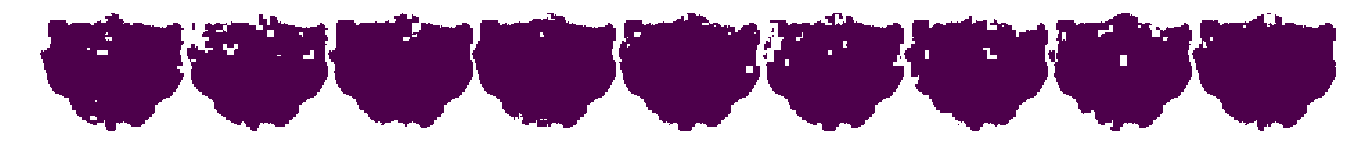

In [121]:
fig = plt.figure(figsize=(10,10))
vmax = .8
beh_idx = 2
for i,fly in enumerate(fly_names):
    ax = fig.add_axes([0+i*.2,1,.2,.2])
    colorbar_c = ax.imshow(masked_XYs[fly][beh_idx][top_edge:bottom_edge,left_edge:right_edge],cmap='BuPu',vmin=0,vmax=vmax);
    ax.axis('off')

In [92]:
fly_names.append('pooled')

In [176]:
fly_names = [ 'pooled',
             'fly_087',
 'fly_089',
 'fly_094',
 'fly_097',
 'fly_098',
 'fly_099',
 'fly_100',
 'fly_101',
 'fly_105']

In [181]:
start = 265-100
end = 235-100
middle = 250-100

# sample the colormaps that you want to use. Use 128 from each so we get 256
# colors in total
colors1 = plt.cm.Blues_r(np.linspace(0., 1, middle-end))
colors2 = plt.cm.Reds(np.linspace(0, 1, start-middle))

# combine them and build a new colormap
colors = np.vstack((colors1, colors2))
mymap = mcolors.LinearSegmentedColormap.from_list('my_colormap', colors)

mymap.set_bad(color='grey')

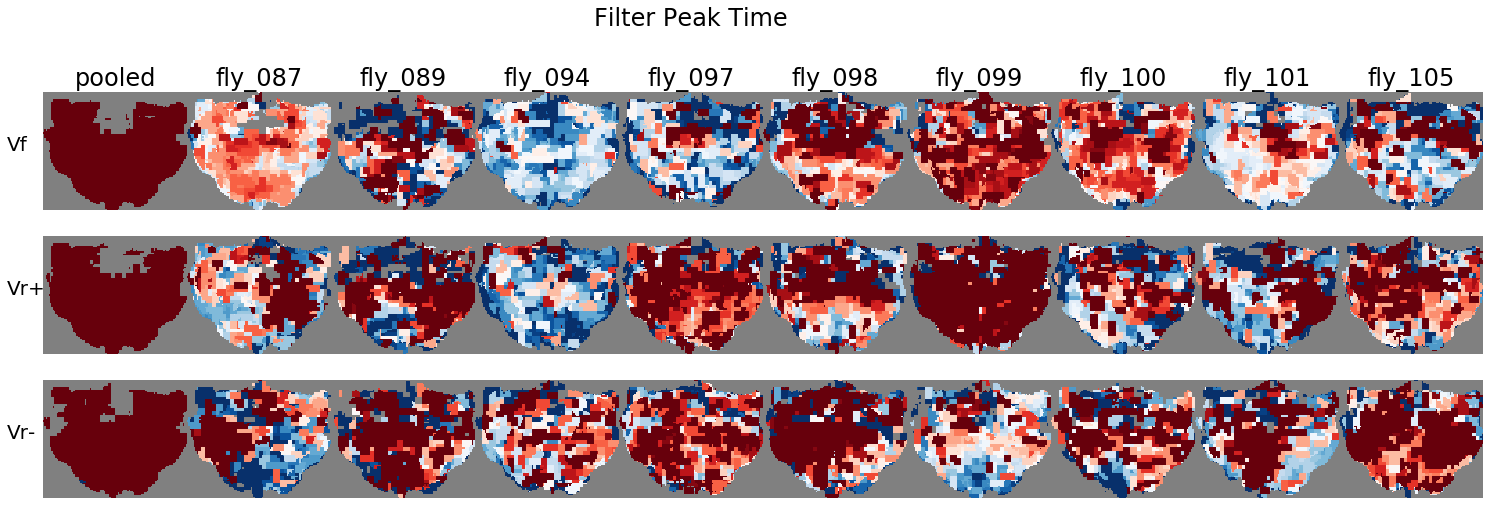

In [182]:
fig = plt.figure(figsize=(10,10))
for beh_idx in [0,1,2]:
    for i,fly in enumerate(fly_names):
        if fly == 'pooled':
            vmax = 3
        else:
            vmax = .8
        ax = fig.add_axes([0+i*.2,1-beh_idx*.2,.2,.2])
        colorbar_c = ax.imshow(masked_XYs[fly][beh_idx][top_edge:bottom_edge,left_edge:right_edge],cmap=mymap,vmin=end,vmax=start);
        ax.axis('off')
        
        if beh_idx == 0:
            plt.title(fly)

fig.text(s='Vf',x=-.05,y=1.1)
fig.text(s='Vr+',x=-.05,y=.9)
fig.text(s='Vr-',x=-.05,y=.7)
fig.suptitle('Filter Peak Time',x=.9,y=1.3)

save_path = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/figs'
timestr = time.strftime("%Y%m%d-%H%M%S")
fname = os.path.join(save_path, f'{timestr}')
#plt.savefig(fname,dpi=300,bbox_inches='tight')

In [155]:
all_data['thresholded_filters_norm']['fly_087'][0]

array([[-93.63608002, -93.70215932, -93.87713893, ..., -24.76909693,
        -24.91106597, -24.95390957],
       [ -3.30247799,  -3.30502562,  -3.31172472, ...,   0.99011128,
          0.99772139,   1.        ],
       [  0.24869513,   0.24840553,   0.24761862, ...,  -1.85778759,
         -1.86677931,  -1.86949163],
       ...,
       [ -4.06407877,  -4.06620917,  -4.07165651, ...,  -1.68161909,
         -1.6871338 ,  -1.68879377],
       [  0.24614415,   0.24618376,   0.24634105, ...,   0.99420454,
          0.99865992,   1.        ],
       [ -0.65943718,  -0.66045186,  -0.66319846, ...,   0.60797856,
          0.60954233,   0.61002151]])

In [168]:
all_data['thresholded_filters_norm']['fly_087'][1].shape

(39200, 500)

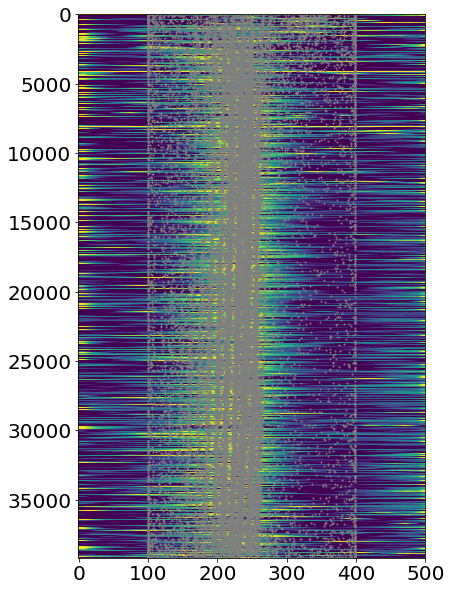

In [170]:
plt.figure(figsize=(10,10))
plt.imshow(all_data['thresholded_filters_norm']['fly_087'][1],aspect=.02,vmin=0,vmax=1)
peaks = np.argmax(all_data['thresholded_filters_norm']['fly_087'][1][:,100:400],axis=-1)
#plt.plot(peaks_)
plt.plot(peaks+100,list(range(len(peaks))),marker='o',linestyle='',color='grey',ms=1)

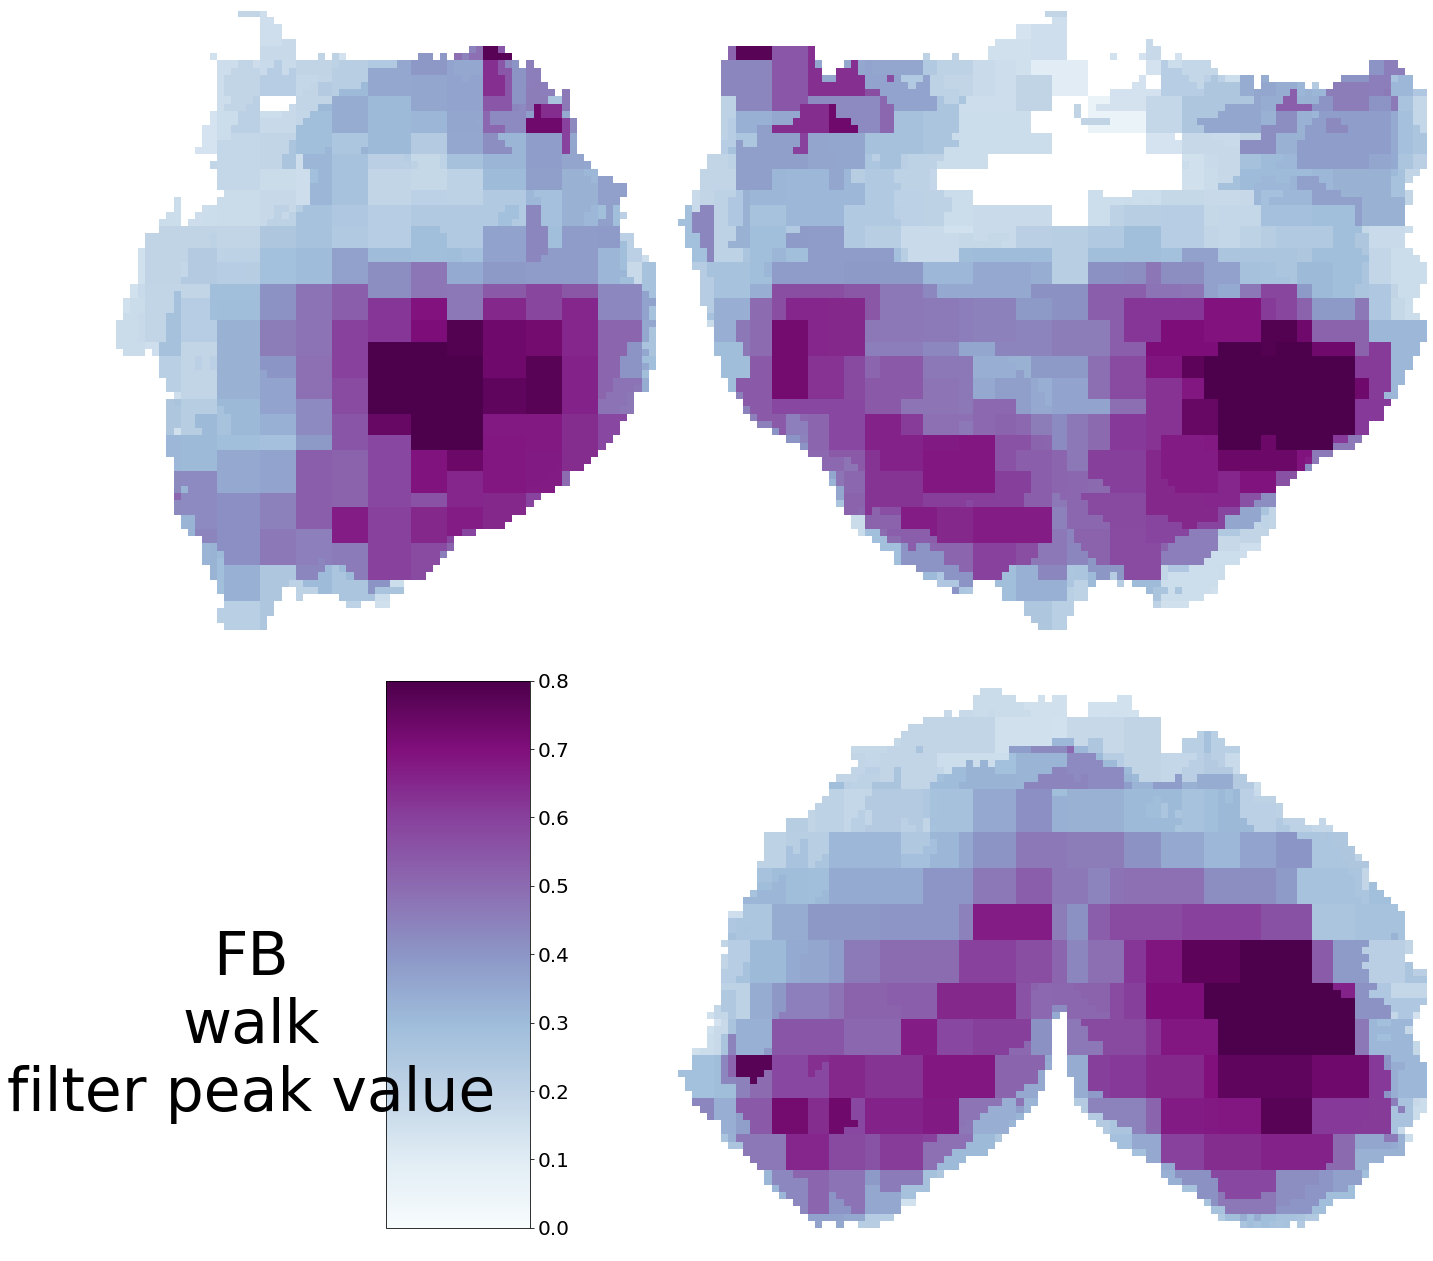

In [48]:
fig = plt.figure(figsize=(10,10))
space = .03
vmax = .8

ax = fig.add_axes([dim_z+space,0,dim_x,dim_y])
colorbar_c = ax.imshow(masked_XY[top_edge:bottom_edge,left_edge:right_edge],cmap='BuPu',vmin=0,vmax=vmax);
ax.axis('off')

ax = fig.add_axes([0,0,dim_z,dim_y])
ax.imshow(masked_YZ[top_edge:bottom_edge, deep_edge:shallow_edge],cmap='BuPu',vmin=0,vmax=vmax);
ax.axis('off')

ax = fig.add_axes([dim_z+space,-dim_y+space,dim_x,dim_z])
ax.imshow(masked_XZ.T[deep_edge:shallow_edge,left_edge:right_edge],cmap='BuPu',vmin=0,vmax=vmax);
ax.axis('off')

plt.suptitle('FB\nwalk\nfilter peak value',fontsize=60,x=dim_z/4,y=(-dim_y+space)/2)

# Color Bar
axColor = plt.axes([dim_z/2,-dim_y+space,.2,dim_y-.1])
cbar = plt.colorbar(colorbar_c, cax = axColor)#, ticks=[start, middle, vmax])
#cbar.ax.set_yticklabels(['300ms\n(Pre)', '0', '300ms\n(Post)'], fontsize=20)

save_path = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/figs'
timestr = time.strftime("%Y%m%d-%H%M%S")
fname = os.path.join(save_path, f'{timestr}')
#plt.savefig(fname,dpi=300,bbox_inches='tight')